In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Load the CSV file
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import math
from scipy.stats import ttest_ind
from statistics import mean, stdev
from itertools import combinations


     L0        L1        L2
0   0.0 -0.602993 -0.587476
1   0.0 -0.035524  -0.78178
2   0.0  0.133407 -0.001253
3   0.0 -0.253369  0.007168
4   0.0 -0.102387  0.397663
5   0.0  0.147324  0.509706
6   0.0 -0.231141 -0.446466
7   0.0  0.166599  0.648525
8   0.0 -0.436921 -0.617255
9   0.0  0.148916 -0.326818
10  0.0  0.307472 -0.056581
     L0        L1        L2
0   0.0 -0.047223 -0.056933
1   0.0  0.009311 -0.061716
2   0.0 -0.007503 -0.019701
3   0.0 -0.036183  0.017698
4   0.0  0.028798   0.04502
5   0.0  0.030674   0.04763
6   0.0  -0.02294 -0.054936
7   0.0  0.004357  0.029033
8   0.0 -0.042307 -0.074427
9   0.0 -0.004742 -0.057992
10  0.0  0.040447  0.004911
     L0        L1        L2
0   0.0  -0.05273  0.048564
1   0.0  0.078158  0.063041
2   0.0 -0.033878 -0.023648
3   0.0  0.000844  0.033061
4   0.0  0.043766  0.041878
5   0.0 -0.030364 -0.008812
6   0.0 -0.172397 -0.211567
7   0.0 -0.054129  -0.00871
8   0.0  0.032686  0.049647
9   0.0  0.104572  0.148289
10  0.0 -0.053174 -0

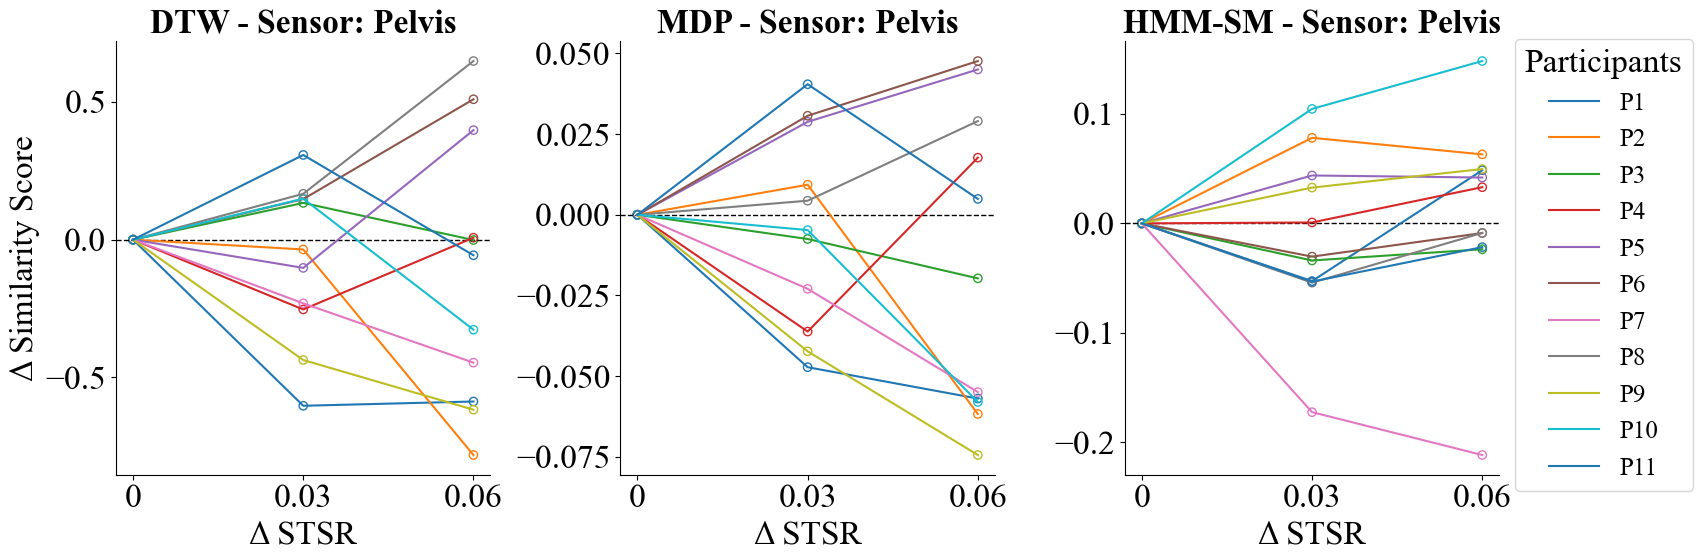

     L0        L1        L2
0   0.0 -2.362431 -1.823632
1   0.0  0.210582 -0.902419
2   0.0  0.813287  1.066284
3   0.0 -0.131829   2.41692
4   0.0 -0.524441  1.282246
5   0.0  -3.86345 -0.847798
6   0.0 -0.328746  0.754585
7   0.0 -1.672157  6.208676
8   0.0  0.347917  2.473756
9   0.0  1.166386  0.561573
10  0.0  1.708896  1.125496
     L0        L1        L2
0   0.0 -0.305673 -0.160919
1   0.0  0.078192 -0.043182
2   0.0  0.103271  0.109261
3   0.0  0.038282  0.428059
4   0.0  0.059101   0.34082
5   0.0 -0.259827 -0.068891
6   0.0  0.005354  0.091778
7   0.0 -0.118023  0.624181
8   0.0  0.055276  0.248937
9   0.0  0.101264  0.063108
10  0.0  0.165544  0.276894
     L0        L1        L2
0   0.0  0.125448  0.100795
1   0.0 -0.053947 -0.055082
2   0.0  0.124491  0.124894
3   0.0 -0.269898  -0.13484
4   0.0  0.085722  0.149366
5   0.0 -0.017849 -0.000337
6   0.0 -0.195199 -0.020366
7   0.0  0.049181  0.066962
8   0.0  0.034887 -0.078831
9   0.0  0.030251   0.00747
10  0.0 -0.035174 -0

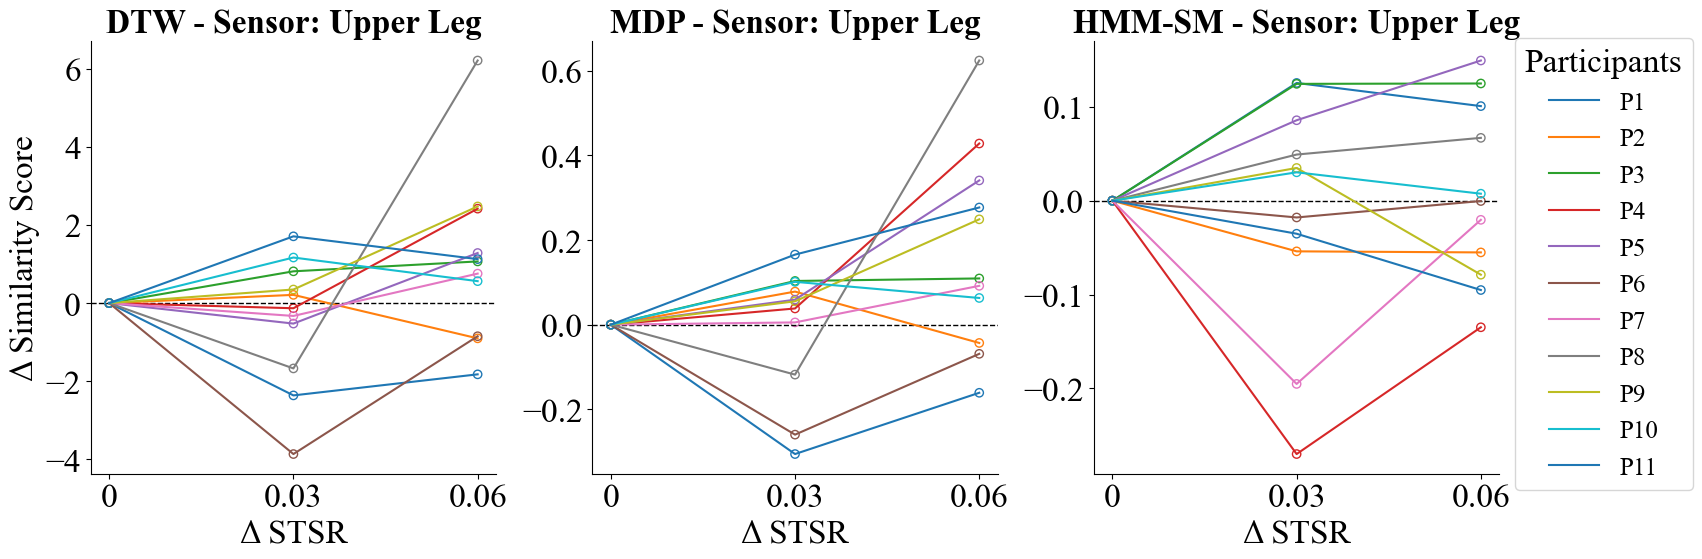

     L0        L1        L2
0   0.0 -0.660006  2.209401
1   0.0 -0.039099 -0.451749
2   0.0  1.935385   2.83223
3   0.0  1.579969  5.066312
4   0.0 -0.566559  1.992123
5   0.0 -2.160115  0.611883
6   0.0 -0.055641  3.430122
7   0.0 -0.042517  4.384669
8   0.0  1.649388  4.138715
9   0.0   1.07755  1.335088
10  0.0  2.520885  2.588656
     L0        L1        L2
0   0.0 -0.149241  0.088837
1   0.0 -0.025199 -0.122009
2   0.0  0.164263  0.261894
3   0.0  0.097856  0.526691
4   0.0 -0.032283  0.262166
5   0.0 -0.088265  0.166255
6   0.0  -0.06281  0.268563
7   0.0 -0.005202  0.433114
8   0.0  0.087437  0.332755
9   0.0  0.130435  0.115403
10  0.0  0.284811  0.409821
     L0        L1        L2
0   0.0  0.013661 -0.035996
1   0.0 -0.013872  0.014786
2   0.0 -0.013761 -0.034799
3   0.0 -0.070248 -0.103389
4   0.0 -0.022441  0.062541
5   0.0  0.017038  0.075961
6   0.0  0.014602 -0.002978
7   0.0 -0.026794 -0.105548
8   0.0 -0.048125 -0.010546
9   0.0  0.146841   0.15549
10  0.0 -0.062399 -0

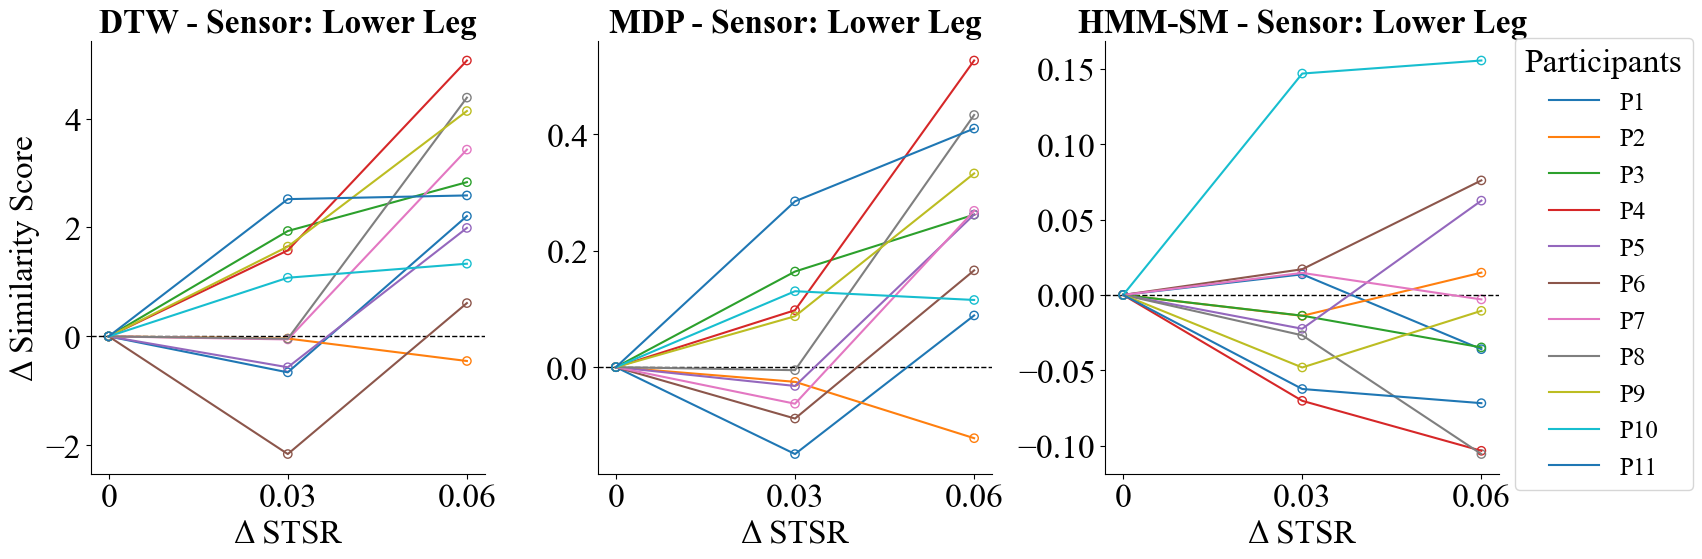

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the data
file_path = fr"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Results\GPS\logresults_16-08-24_18-14_GPS.csv"
data = pd.read_csv(file_path, header=None)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

def calculate_srm(col1, col2):
    valid_indices = ~col1.isna() & ~col2.isna()
    if np.any(valid_indices):
        mean_diff = np.mean(col1[valid_indices] - col2[valid_indices])
        std_diff = np.std((col1[valid_indices] - col2[valid_indices]), ddof=1)
        return mean_diff / std_diff
    else:
        return np.nan

def calculate_cohens_d(group1, group2):
    mean_diff = mean(group1) - mean(group2)
    pooled_std = np.sqrt((stdev(group1)**2 + stdev(group2)**2) / 2)
    return mean_diff / pooled_std

# Function to plot scatter plots
def plot_scatter(data, sensor):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"

    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    
    algorithms = list(data['Algorithm'].unique())
    
    #Makes sure it is the last one 
    if "HMM-SM" in algorithms:
        algorithms.remove("HMM-SM")
        algorithms.append("HMM-SM")
        
    colorslist = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = [colorslist[i % len(colorslist)] for i in range(11)]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure for subplots
    
    for idx, algorithm in enumerate(algorithms):
        subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
        df = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(subset['Participant'].unique())))
        df_ydiff = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(subset['Participant'].unique())))
        if not subset.empty:
            ax = axs[idx]
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.axhline(y=0,linestyle='--',linewidth=1,color='k')
            for i, participant in enumerate(subset['Participant'].unique()):
                participant_data = subset[subset['Participant'] == participant].copy()
                if algorithm == "HMM-SM":
                    participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
                Y = participant_data['Y']
                participant_data['Y_diff'] = participant_data['Y'] - participant_data['Y'].iloc[0]
                Y_diff = participant_data['Y_diff'].values.tolist()
                df.loc[i] = Y
                
                df_ydiff.loc[i] = Y_diff
                ax.plot(['0', '0.03', '0.06'], Y_diff, label=f"P{i+1}")
                ax.scatter(['0', '0.03', '0.06'], Y_diff, marker='o', edgecolors=colors[i], facecolors='none')
                #ax.set_ylim(bottom=0)
            ax.set_xlabel("Δ STSR", fontsize=24)
            ax.tick_params(axis='both', which='major', labelsize=24)
            if idx == 0:
                ax.set_ylabel("Δ Similarity Score", fontsize=24)  # Only on the leftmost plot
            ax.set_title(f"{algorithm} - Sensor: {sensor_titles[sensor]}", fontsize=24, fontweight='bold')
            print(f"{algorithm},{sensor}")
            print(df_ydiff)
    # Single legend outside the plot, but closer to the subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.95, 0.5), title="Participants",fontsize=18,title_fontsize=24)
    
    # Adjust the layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust rect to leave space for the title and legend
    
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    #plt.suptitle(f"Sensor: {sensor_titles[sensor]}", x=0.5,y=1, fontsize=18)  # Larger sensor title, not bold
    
    #plt.savefig(fr"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Results\STSR\logresults_16-08-24_23-07_{sensor}_Scatter_STSR.svg", bbox_inches='tight')
    plt.show()

# Function to plot error bar plots
def plot_error_bars(data, sensor):
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    algorithms = list(data['Algorithm'].unique())
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure for subplots
    
    for idx, algorithm in enumerate(algorithms):
        subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
        df = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(subset['Participant'].unique())))
        
        if not subset.empty:
            ax = axs[idx]
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            for i, participant in enumerate(subset['Participant'].unique()):
                participant_data = subset[subset['Participant'] == participant].copy()
                if algorithm == "HMM-SM":
                    participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
                Y = participant_data['Y']
                df.loc[i] = Y
                
            #print(df)
            mean_values = df.mean()
            #print(mean_values)
            sem_values = df.sem()
            x_labels = df.columns
            ax.errorbar(['0', '0.4', '0.8'], mean_values[1:], yerr=1.96 * sem_values[1:], fmt='o', capsize=5, color='black')
            ax.set_xlabel('Δ GPS', fontsize=14)
            ax.set_xticklabels()
            if idx == 0:
                ax.set_ylabel('Similarity', fontsize=14)  # Only on the leftmost plot
            ax.set_title(f"{algorithm} - Sensor: {sensor_titles[sensor]}", fontsize=14, fontweight='bold')
    
    sensor_titles = {'upper': 'Upper Leg', 'lower': 'Lower Leg', 'pelvis': 'Pelvis'}
    #plt.suptitle(f"Sensor: {sensor_titles[sensor]}", x=0.5,y=1, fontsize=18)  # Larger sensor title, not bold
    
    #plt.savefig(f"Q:\main_propellab\Users\Ng, Gabe\Summer Student 2024\Manuscript\Results\GPS\logresults_16-08-24_18-14_GPS_{sensor}_ErrorBars_GPS.svg", bbox_inches='tight')
    plt.show()

sensors = data['Sensor'].unique()

# Plot for each sensor across all algorithms
for sensor in sensors:
    plot_scatter(data, sensor)
    #plot_error_bars(data, sensor)

In [1]:



import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
# Load the CSV file
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import math
from scipy.stats import ttest_ind
from statistics import mean, stdev
from itertools import combinations
import pingouin as pg
import os


t_test_results = {}
file_path = r"C:\GP-WearablesAnalysis\examples\logresults_16-08-24_13-20_STSR.csv"
data = pd.read_csv(file_path, header=None)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

# Function to perform paired t-tests and apply BH correction
def analysis_byalgorithm(data, algorithm, sensor):
    
    # Initialize DataFrame to hold data for each participant
    
    subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
    print(f'Generating results for {algorithm}, {sensor}, number of data points: {len(subset)}')
    df = pd.DataFrame(columns=['L0', 'L1','L2'], index=range(len(data['Participant'].unique())))  # Initialize outside the loop
    
    if not subset.empty:
        for i, participant in enumerate(subset['Participant'].unique()):
            participant_data = subset[subset['Participant'] == participant].copy()
            if algorithm == "HMM-SM":
                participant_data = participant_data.iloc[1:] #Existing data also contains the BL-BL comparison (between trained models). Want to remove this.
            Y = participant_data['Y'].values.tolist()
            df.loc[i] = Y     
       
    # Drop participants with any missing data across the conditions
    df.dropna(inplace=True)
    print(df)
    if df.empty:
        print("No complete data available for paired t-tests.")
        return
    
    # List of columns (conditions) to compare
    columns = df.columns.tolist()
    
    # Generate all unique pairs of conditions
    pairs = list(combinations(columns, 2))
    
    # Exclude specific pairs if necessary
    #excluded_pairs = [('BL', 'L1'), ('BL', 'L2'),('BL', 'L0')]  # Exclude comparisons to the second baseline group
    filtered_pairs = [pair for pair in pairs]
    
    # Prepare lists to store p-values and their corresponding pairs
    p_values = []
    p_value_pairs = []
    t_test_results = {}
    
    # Perform paired t-tests using pingouin and calculate SRM
    for col1, col2 in filtered_pairs:
        data1 = df[col1].astype(float)
        data2 = df[col2].astype(float)
        
        
        # Calculate SRM
        difference = data1 - data2
        mean_diff = np.mean(difference)
        std_diff = np.std(difference, ddof=1)
        srm = mean_diff / std_diff if std_diff != 0 else np.nan
        normality_res = pg.normality(difference)
        p_normality = normality_res['pval'].values[0]
        
        if p_normality > 0.05:
            print("Data is normally distributed")
            pair_name = f'{col1}_vs_{col2}'
            # Perform paired t-test
            ttest_res = pg.ttest(data1, data2, paired=True)
            t_stat = ttest_res['T'].values[0]
            p_val = ttest_res['p-val'].values[0]
            t_test_results[pair_name] = {'t_statistic': t_stat, 'p_value': p_val, 'srm': srm}
        else:
            print("Data is not normally distributed")
            pair_name = f'{col1}_vs_{col2}'
            ttest_res = pg.ttest(data1, data2, paired=True)
            t_stat = ttest_res['T'].values[0]
            p_val = ttest_res['p-val'].values[0]
            t_test_results[pair_name] = {'t_statistic': t_stat, 'p_value': p_val, 'srm': srm}
        
        # Collect p-values for BH correction
        p_values.append(p_val)
        p_value_pairs.append(pair_name)
    
    # Apply Benjamini-Hochberg correction
    bh_results = pg.multicomp(p_values, method='fdr_bh')
    corrected_p_values = bh_results[1]
    
    # Map corrected p-values to their corresponding pairs
    corrected_p_value_mapping = dict(zip(p_value_pairs, corrected_p_values))
    
    # Display results
    for pair in t_test_results:
        t_stat = t_test_results[pair]['t_statistic']
        raw_p_val = t_test_results[pair]['p_value']
        corrected_p_val = corrected_p_value_mapping[pair]
        srm = t_test_results[pair]['srm']
        significance = 'Yes' if corrected_p_val < 0.05 else 'No'
        
        print(f"{pair}: t-statistic = {t_stat:.3f}, "
              f"p-value = {raw_p_val:.3f}, "
              f"BH-adjusted p-value = {corrected_p_val:.3f}, "
              f"SRM = {srm:.3f}, "
              f"Significant = {significance}")
    
    # Append t-test results to CSV
    csv_file2 = r"C:\GP-WearablesAnalysis\examples\logresults_16-08-24_13-20_STSR_Statistics_results.csv"
    if not os.path.exists(csv_file2):
        with open(csv_file2, "w") as file:
            file.write("Algorithm,Sensor,Comparison,T-statistic,Raw p-value,BH-adjusted p-value,SRM\n")
            
    # Prepare data for CSV
    with open(csv_file2, "a") as file:
        for pair in t_test_results:
            t_stat = t_test_results[pair]['t_statistic']
            raw_p_val = t_test_results[pair]['p_value']
            corrected_p_val = corrected_p_value_mapping[pair]
            srm = t_test_results[pair]['srm']
            if not os.path.exists(csv_file2):
                file.write(f"{algorithm}, {sensor}, {pair}, {t_stat}, {raw_p_val}, {corrected_p_val}, {srm}\n")
    
    print(f"Results appended to {csv_file2}")

# Get unique combinations of sensors and algorithms
sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

# Perform analysis for each combination of sensor and algorithm
for sensor in sensors:
    for algorithm in algorithms:
        analysis_byalgorithm(data, algorithm, sensor)


Generating results for DTW, pelvis, number of data points: 33
           L0         L1         L2
0   17.212967   15.73653  15.964791
1   16.469304  16.594263  16.039862
2   10.188091  10.414128  10.378146
3   14.505012  14.076522  14.260526
4   18.496761  18.535391  17.942449
5   17.321716  17.324329  17.771173
6   12.331017   11.80899  11.683521
7   12.770234  12.668555  13.261765
8   12.617161  12.565766   12.26369
9   15.644134  16.331891  16.089443
10  15.945659  15.783457  15.675426
Data is normally distributed
Data is normally distributed
Data is normally distributed
L0_vs_L1: t-statistic = 0.920, p-value = 0.379, BH-adjusted p-value = 0.569, SRM = 0.278, Significant = No
L0_vs_L2: t-statistic = 1.200, p-value = 0.258, BH-adjusted p-value = 0.569, SRM = 0.362, Significant = No
L1_vs_L2: t-statistic = 0.403, p-value = 0.696, BH-adjusted p-value = 0.696, SRM = 0.121, Significant = No
Results appended to C:\GP-WearablesAnalysis\examples\logresults_16-08-24_13-20_STSR_Statistics_res

In [6]:
""" T-test, benjamini-hochberg correction and SRM for each comparison level"""
import numpy as np
import pandas as pd
import pingouin as pg
import os
from itertools import combinations

# Function to calculate SRM
def calculate_srm(data1, data2):
    difference = data1 - data2
    mean_diff = np.mean(difference)
    std_diff = np.std(difference, ddof=1)
    return mean_diff / std_diff if std_diff != 0 else np.nan

# Reading the data
file_path = r"C:\GP-WearablesAnalysis\examples\logresults_16-08-24_23-07_STSR2.csv"
data = pd.read_csv(file_path, header=None)
data.columns = ['FilePath', 'Sensor', 'GaitParam', 'Algorithm', 'Participant', 'X', 'Y']
data['Y'] = pd.to_numeric(data['Y'], errors='coerce')

# Function to perform pairwise tests using pingouin's pairwise_tests and save results to CSV
def analysis_byalgorithm(data, algorithm, sensor, parametric=True, correction='fdr_bh'):
    subset = data[(data['Algorithm'] == algorithm) & (data['Sensor'] == sensor)]
    print(f'Generating results for {algorithm}, {sensor}, number of data points: {len(subset)}')

    # Prepare the DataFrame with the relevant data for pairwise comparisons
    df = pd.DataFrame(columns=['L0', 'L1', 'L2'], index=range(len(data['Participant'].unique())))  # Initialize outside the loop
    
    if not subset.empty:
        for i, participant in enumerate(subset['Participant'].unique()):
            participant_data = subset[subset['Participant'] == participant].copy()
            if algorithm == "HMM-SM":
                participant_data = participant_data.iloc[1:]  # Remove the first entry for HMM-SM
            Y = participant_data['Y'].values.tolist()
            df.loc[i] = Y

    # Drop participants with any missing data across the conditions
    df.dropna(inplace=True)

    if df.empty:
        print("No complete data available for pairwise comparisons.")
        return
    print(df)
    # Reshape DataFrame for pairwise comparison
    df_melted = df.reset_index().melt(id_vars=['index'], var_name='Level', value_name='Y')
    df_melted.rename(columns={'index': 'Participant'}, inplace=True)
    df_melted['Y'] = pd.to_numeric(df_melted['Y'], errors='coerce')
    df_melted.dropna(subset=['Y'], inplace=True)

    # Perform pairwise comparisons using pingouin
    results = pg.pairwise_tests(
        dv='Y', 
        within='Level', 
        subject='Participant', 
        data=df_melted, 
        parametric=parametric, 
        padjust=correction, 
        effsize='cohen'
    )

    # Calculate SRM for each comparison
    srm_values = {}
    normality = {}
    levels = ['L0', 'L1', 'L2']
    pairs = list(combinations(levels, 2))
    for level1, level2 in pairs:
        data1 = df[df.columns[df.columns.get_loc(level1)]].astype(float)
        data2 = df[df.columns[df.columns.get_loc(level2)]].astype(float)
        if not data1.empty and not data2.empty:
            difference = data1 - data2
            mean_diff = np.mean(difference)
            std_diff = np.std(difference, ddof=1)
            srm =  mean_diff / std_diff if std_diff != 0 else np.nan
            srm_values[f'{level1}_vs_{level2}'] = srm
            
            normality_res = pg.normality(difference)
            p_normality = normality_res['pval'].values[0]
        
            if p_normality > 0.05:
                normality_value = True
            else:
                normality_value = p_normality
            normality[f'{level1}_vs_{level2}'] = normality_value
        else:
            print(f"Data for {level1} or {level2} is empty.")
            srm_values[f'{level1}_vs_{level2}'] = np.nan


    # Add sensor and algorithm columns to the results
    results['Sensor'] = sensor
    results['Algorithm'] = algorithm

    # Add SRM to the results DataFrame
    results['SRM'] = results.apply(lambda row: srm_values.get(f'{row["A"]}_vs_{row["B"]}', np.nan), axis=1)
    results['Normality'] = results.apply(lambda row: normality.get(f'{row["A"]}_vs_{row["B"]}', np.nan), axis=1)
    # Reorder columns to make 'Sensor' and 'Algorithm' the leftmost columns
    results = results[['Sensor', 'Algorithm'] + [col for col in results.columns if col not in ['Sensor', 'Algorithm']]]

    # File path for the CSV
    csv_file2 = r"C:\GP-WearablesAnalysis\examples\logresults_16-08-24_23-07_STSR2_stats.csv"
    # Write header if the file does not exist
    if not os.path.exists(csv_file2):
        results.to_csv(csv_file2, index=False)
    else:
        results.to_csv(csv_file2, mode='a', header=False, index=False)

    print(f"Results appended to {csv_file2}")

# Get unique combinations of sensors and algorithms
sensors = data['Sensor'].unique()
algorithms = data['Algorithm'].unique()

# Perform analysis for each combination of sensor and algorithm
for sensor in sensors:
    for algorithm in algorithms:
        analysis_byalgorithm(data, algorithm, sensor, parametric=False, correction='fdr_bh')  # Set parametric to True or False as needed

Generating results for DTW, pelvis, number of data points: 33
           L0         L1         L2
0   16.971961  16.368968  16.384485
1   16.607418  16.571894  15.825638
2    10.28702  10.420427  10.285767
3   14.480315  14.226947  14.487483
4   18.287274  18.184886  18.684936
5   17.368491  17.515815  17.878197
6   12.132578  11.901437  11.686111
7   12.491599  12.658198  13.140123
8   12.315504  11.878584  11.698249
9    15.73067  15.879586  15.403852
10  15.644003  15.951475  15.587422
Results appended to C:\GP-WearablesAnalysis\examples\logresults_16-08-24_23-07_STSR2_stats.csv
Generating results for MDP, pelvis, number of data points: 33
          L0        L1        L2
0   0.935062   0.88784   0.87813
1   0.936498  0.945809  0.874782
2   0.604507  0.597004  0.584806
3   0.805507  0.769325  0.823205
4   0.954632   0.98343  0.999651
5   0.964937   0.99561  1.012567
6   0.742556  0.719616   0.68762
7   0.746126  0.750483  0.775159
8   0.663406  0.621098  0.588978
9   0.874401  0.869

In [10]:
import pandas as pd

# Load the original CSV file
file = r"C:\GP-WearablesAnalysis\examples\results_groupinfo_STSR_trial.csv"
df = pd.read_csv(file)  # Replace "your_file.csv" with your actual file name

# Function to calculate [Min, Max] for each participant
def calculate_min_max(df):
    participants = df['Participant'].unique()
    min_max_list = []

    for participant in participants:
        # Filter data for the current participant
        participant_data = df[df['Participant'] == participant]
        
        # Calculate min and max
        min_value = participant_data['Min'].min()
        max_value = participant_data['Max'].max()
        
        # Append the result as a dictionary
        min_max_list.append({
            "Participant": participant,
            "Min-Max": f"[{round(min_value,2)}, {round(max_value,2)}]"
        })

    # Create a new DataFrame for the Min-Max table
    min_max_df = pd.DataFrame(min_max_list)
    return min_max_df

# Calculate the [Min, Max] for each participant
min_max_df = calculate_min_max(df)

# Save the new DataFrame to a separate CSV file
min_max_df.to_csv(file, index=False)

print("Min-Max table has been saved to 'min_max_table.csv'.")

Min-Max table has been saved to 'min_max_table.csv'.
